In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
try:
    # For newer matplotlib versions
    plt.style.use('seaborn')
except:
    # For older matplotlib versions
    plt.style.use('default')

# Seaborn settings
sns.set_theme(style="whitegrid")
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
pathmentalhealth = '../data/cleaned_mental_health_dataset.csv'
pathscreentime = '../data/cleaned_screen_time_dataset.csv'

mental_health_df = pd.read_csv(pathmentalhealth)
screen_time_df = pd.read_csv(pathscreentime)

In [4]:
mental_health_df['age_group'] = pd.cut(
    mental_health_df['age'], 
    bins=[0, 18, 30, 45, 60, 100], 
    labels=['Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior'],
    include_lowest=True
)

# Add a new incremental ID column starting from 1
screen_time_df['new_id'] = range(1, len(screen_time_df) + 1)

# If you want to replace the original user_id column with this new ID:
screen_time_df['user_id'] = screen_time_df['new_id']

# Then drop the temporary new_id column if you don't need it anymore
screen_time_df = screen_time_df.drop(columns=['new_id'])

mental_health_df['total_screen_time_type_score'] = (
    mental_health_df['phone_usage_hours'] +
    mental_health_df['laptop_usage_hours'] +
    mental_health_df['tablet_usage_hours'] +
    mental_health_df['tv_usage_hours']
)

## Screen Impact : Is it benefic or harmful ?

#### How many hours do you pass in daily screen?

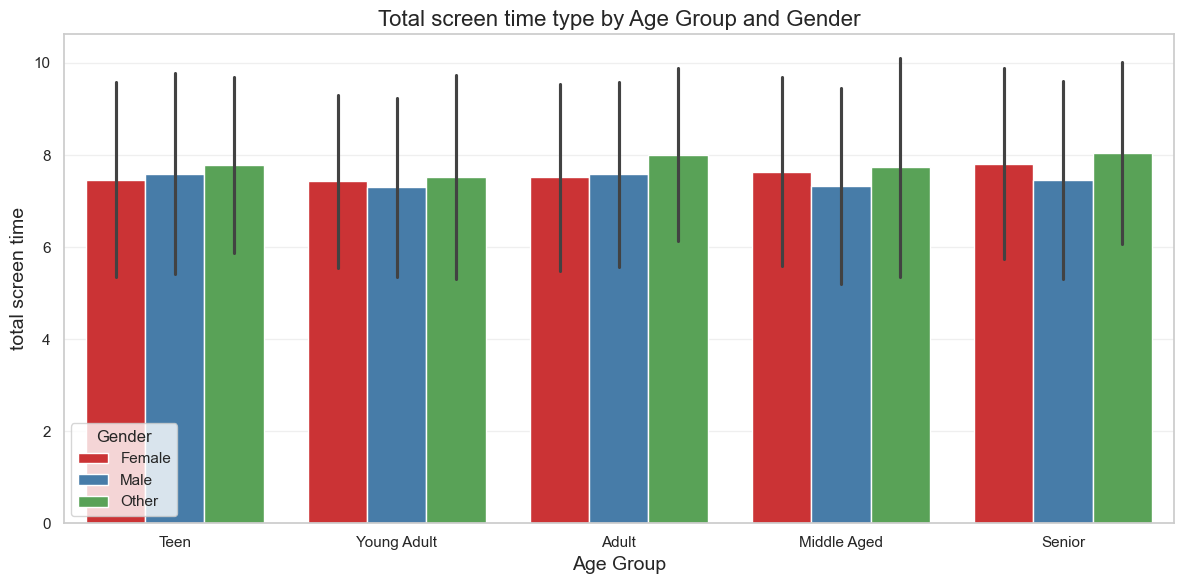

In [5]:

plt.figure(figsize=(12, 6))
sns.barplot(
    x='age_group',
    y='total_screen_time_type_score',
    hue='gender',
    data=mental_health_df,
    palette='Set1',
    ci='sd'
)

plt.title('Total screen time type by Age Group and Gender', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('total screen time', fontsize=14)
plt.grid(True, axis='y', alpha=0.3)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [6]:
group_means = mental_health_df.groupby(['age_group', 'gender'])['total_screen_time_type_score'].mean().reset_index()

print(group_means)
print("mean of everybody :",group_means['total_screen_time_type_score'].mean())

      age_group  gender  total_screen_time_type_score
0          Teen  Female                      7.467290
1          Teen    Male                      7.593519
2          Teen   Other                      7.776471
3   Young Adult  Female                      7.427451
4   Young Adult    Male                      7.300535
5   Young Adult   Other                      7.521429
6         Adult  Female                      7.514388
7         Adult    Male                      7.576806
8         Adult   Other                      8.005455
9   Middle Aged  Female                      7.637500
10  Middle Aged    Male                      7.326531
11  Middle Aged   Other                      7.731579
12       Senior  Female                      7.805405
13       Senior    Male                      7.458228
14       Senior   Other                      8.041667
mean of everybody : 7.612283449043935


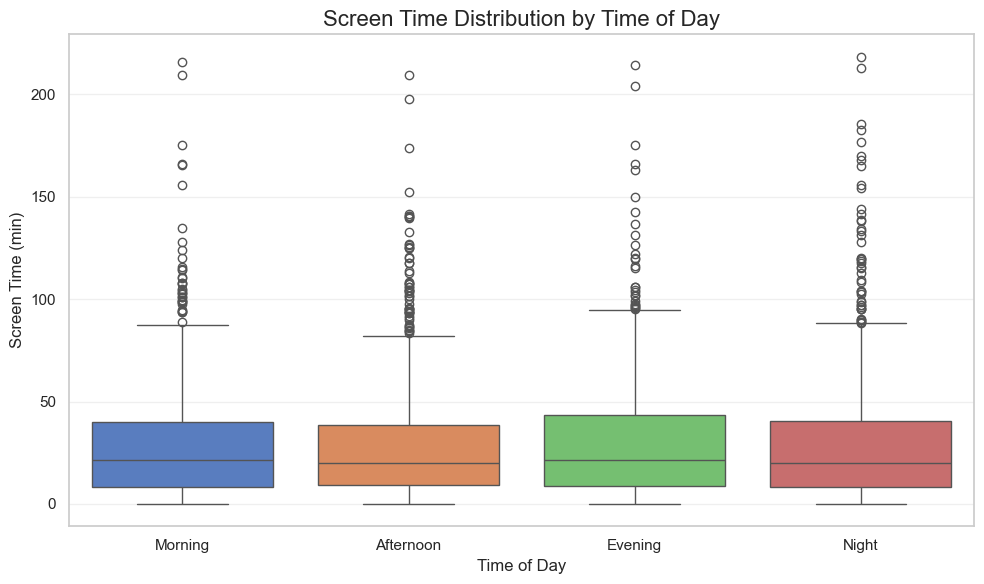

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=screen_time_df, x='time_of_day', y='screen_time_min', order=['Morning', 'Afternoon', 'Evening', 'Night'], palette='muted')
plt.title('Screen Time Distribution by Time of Day', fontsize=16)
plt.xlabel('Time of Day')
plt.ylabel('Screen Time (min)')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to your data
cleaned_df = remove_outliers_iqr(screen_time_df, 'screen_time_min')

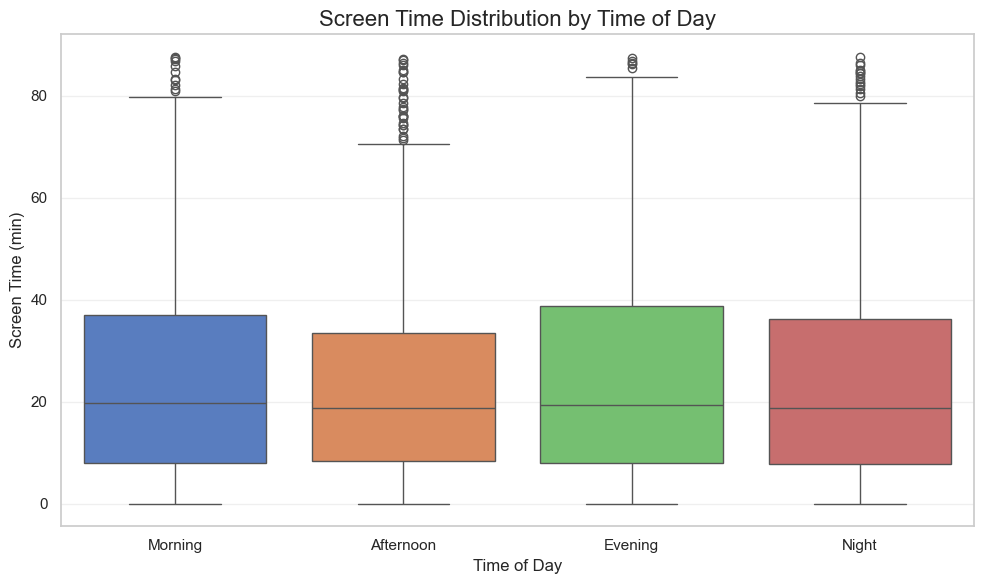

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_df, x='time_of_day', y='screen_time_min', order=['Morning', 'Afternoon', 'Evening', 'Night'], palette='muted')
plt.title('Screen Time Distribution by Time of Day', fontsize=16)
plt.xlabel('Time of Day')
plt.ylabel('Screen Time (min)')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### On which apps?

#### Correlations

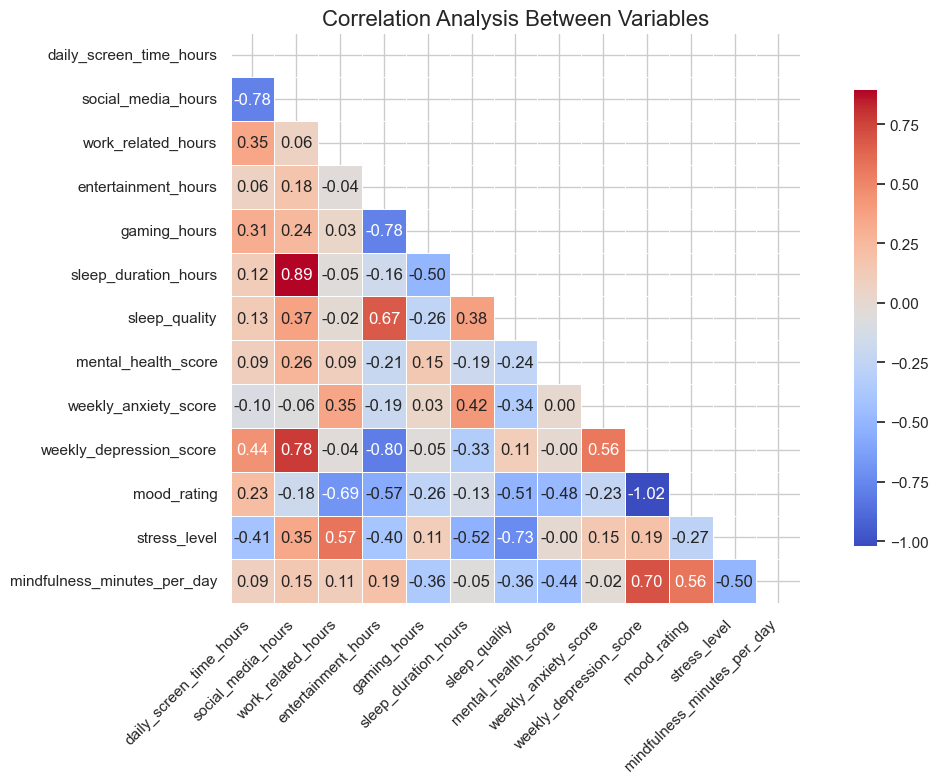

In [ ]:
cols_to_analyze = ['daily_screen_time_hours', 'social_media_hours', 'work_related_hours', 
                  'entertainment_hours', 'gaming_hours', 'sleep_duration_hours', 'sleep_quality', 
                  'mental_health_score', 'weekly_anxiety_score', 'weekly_depression_score',
                  'mood_rating', 'stress_level', 'mindfulness_minutes_per_day']

# Calculate correlation matrix
corr_matrix = mental_health_df[cols_to_analyze].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix*16, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True,
           linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Analysis Between Variables', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Sleep

In [9]:
from mpl_toolkits.mplot3d import Axes3D

night_usage = screen_time_df[screen_time_df['time_of_day'] == 'Night']

# Ensure user_id is the same type in both DataFrames
mental_health_df['user_id'] = mental_health_df['user_id'].str.extract('(\d+)').astype(int).astype(str)
screen_time_df['user_id'] = screen_time_df['user_id'].astype(str)

# Now filter and merge as before
night_usage = screen_time_df[screen_time_df['time_of_day'] == 'Night']
night_screen_time = night_usage.groupby('user_id')['screen_time_min'].sum().reset_index()
night_screen_time.rename(columns={'screen_time_min': 'night_screen_time_min'}, inplace=True)

# Merge safely now that both user_id columns are string type
merged_df = mental_health_df.merge(night_screen_time, on='user_id', how='left')
merged_df['night_screen_time_min'] = merged_df['night_screen_time_min'].fillna(0)

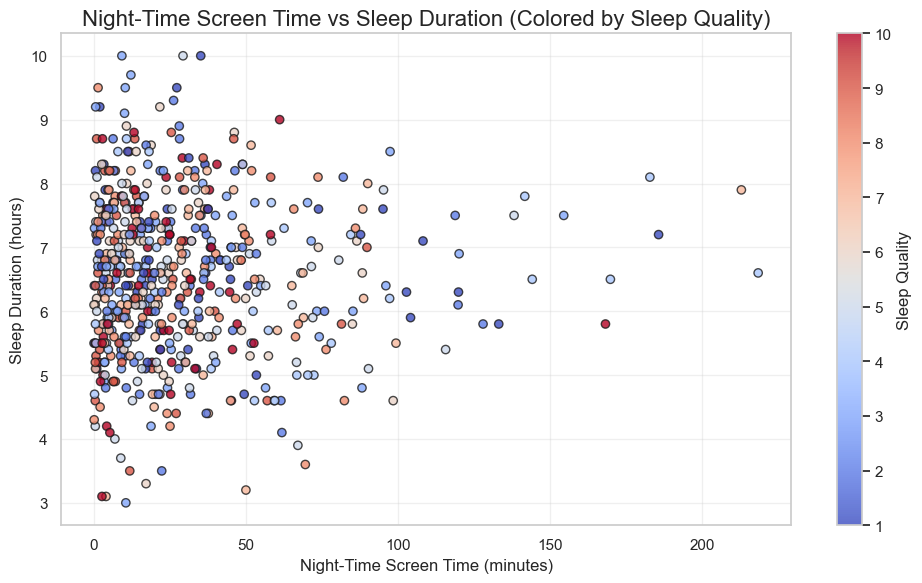

In [10]:
filtered_df = merged_df[merged_df['night_screen_time_min'] != 0]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    filtered_df['night_screen_time_min'],
    filtered_df['sleep_duration_hours'],
    c=filtered_df['sleep_quality'],
    cmap='coolwarm',
    edgecolor='k',
    alpha=0.8
)

plt.colorbar(scatter, label='Sleep Quality')
plt.title('Night-Time Screen Time vs Sleep Duration (Colored by Sleep Quality)', fontsize=16)
plt.xlabel('Night-Time Screen Time (minutes)')
plt.ylabel('Sleep Duration (hours)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


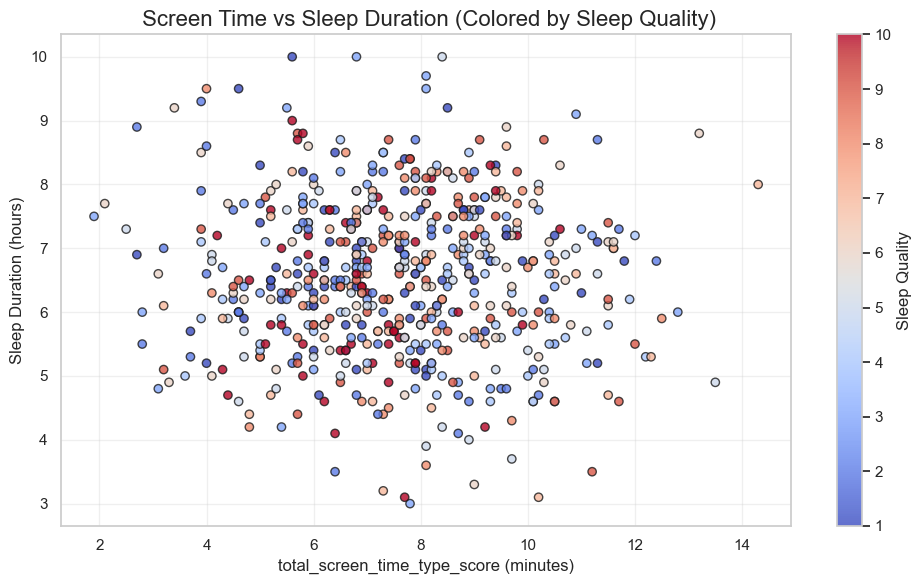

In [11]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    filtered_df['total_screen_time_type_score'],
    filtered_df['sleep_duration_hours'],
    c=filtered_df['sleep_quality'],
    cmap='coolwarm',
    edgecolor='k',
    alpha=0.8
)

plt.colorbar(scatter, label='Sleep Quality')
plt.title(' Screen Time vs Sleep Duration (Colored by Sleep Quality)', fontsize=16)
plt.xlabel('total_screen_time_type_score (minutes)')
plt.ylabel('Sleep Duration (hours)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Sleep Duration (hours)')

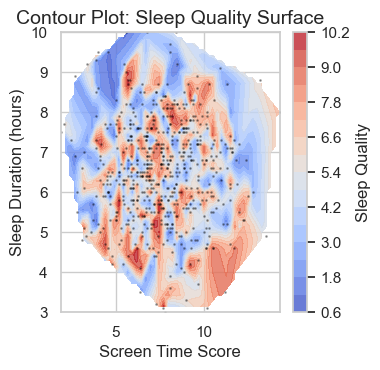

In [12]:
plt.subplot(2, 3, 3)
# Create a grid for contour plotting
x = filtered_df['total_screen_time_type_score']
y = filtered_df['sleep_duration_hours']
z = filtered_df['sleep_quality']

# Create grid
xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
Xi, Yi = np.meshgrid(xi, yi)

# Interpolate z values
from scipy.interpolate import griddata
Zi = griddata((x, y), z, (Xi, Yi), method='linear')

contour = plt.contourf(Xi, Yi, Zi, levels=15, cmap='coolwarm', alpha=0.8)
plt.colorbar(contour, label='Sleep Quality')
plt.scatter(x, y, c='black', s=1, alpha=0.3)
plt.title('Contour Plot: Sleep Quality Surface', fontsize=14)
plt.xlabel('Screen Time Score')
plt.ylabel('Sleep Duration (hours)')

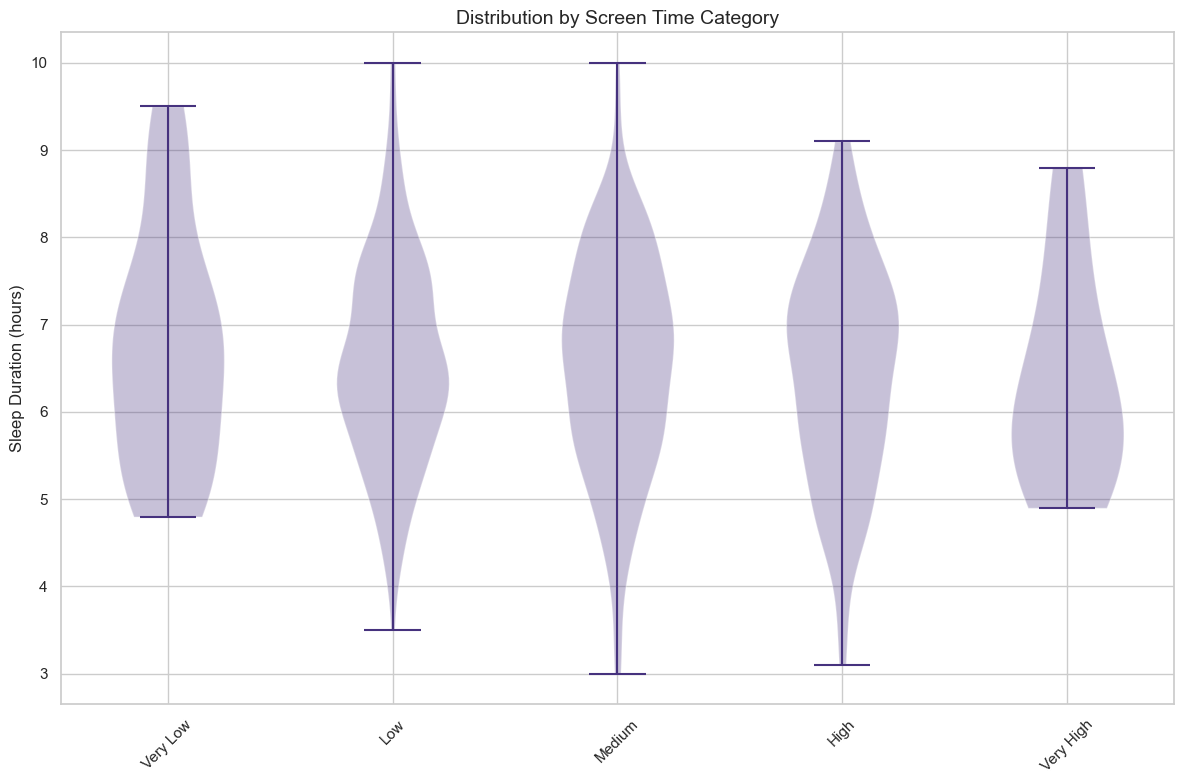

In [13]:
filtered_df['screen_category'] = pd.cut(filtered_df['total_screen_time_type_score'], 
                                       bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Create violin plot
parts = plt.violinplot([filtered_df[filtered_df['screen_category'] == cat]['sleep_duration_hours'].dropna() 
                       for cat in filtered_df['screen_category'].cat.categories if 
                       not filtered_df[filtered_df['screen_category'] == cat]['sleep_duration_hours'].empty],
                      positions=range(len(filtered_df['screen_category'].cat.categories)))

plt.xticks(range(len(filtered_df['screen_category'].cat.categories)), 
           filtered_df['screen_category'].cat.categories, rotation=45)
plt.ylabel('Sleep Duration (hours)')
plt.title('Distribution by Screen Time Category', fontsize=14)

plt.tight_layout()
plt.show()



Data shape: (591, 3)
Features: ['total_screen_time_type_score', 'sleep_duration_hours', 'sleep_quality']
First few rows:
   total_screen_time_type_score  sleep_duration_hours  sleep_quality
0                           7.9                   6.6              6
1                           8.2                   4.5              7
2                           7.6                   7.1              9
3                           3.2                   5.1              9
4                           5.9                   7.4              2


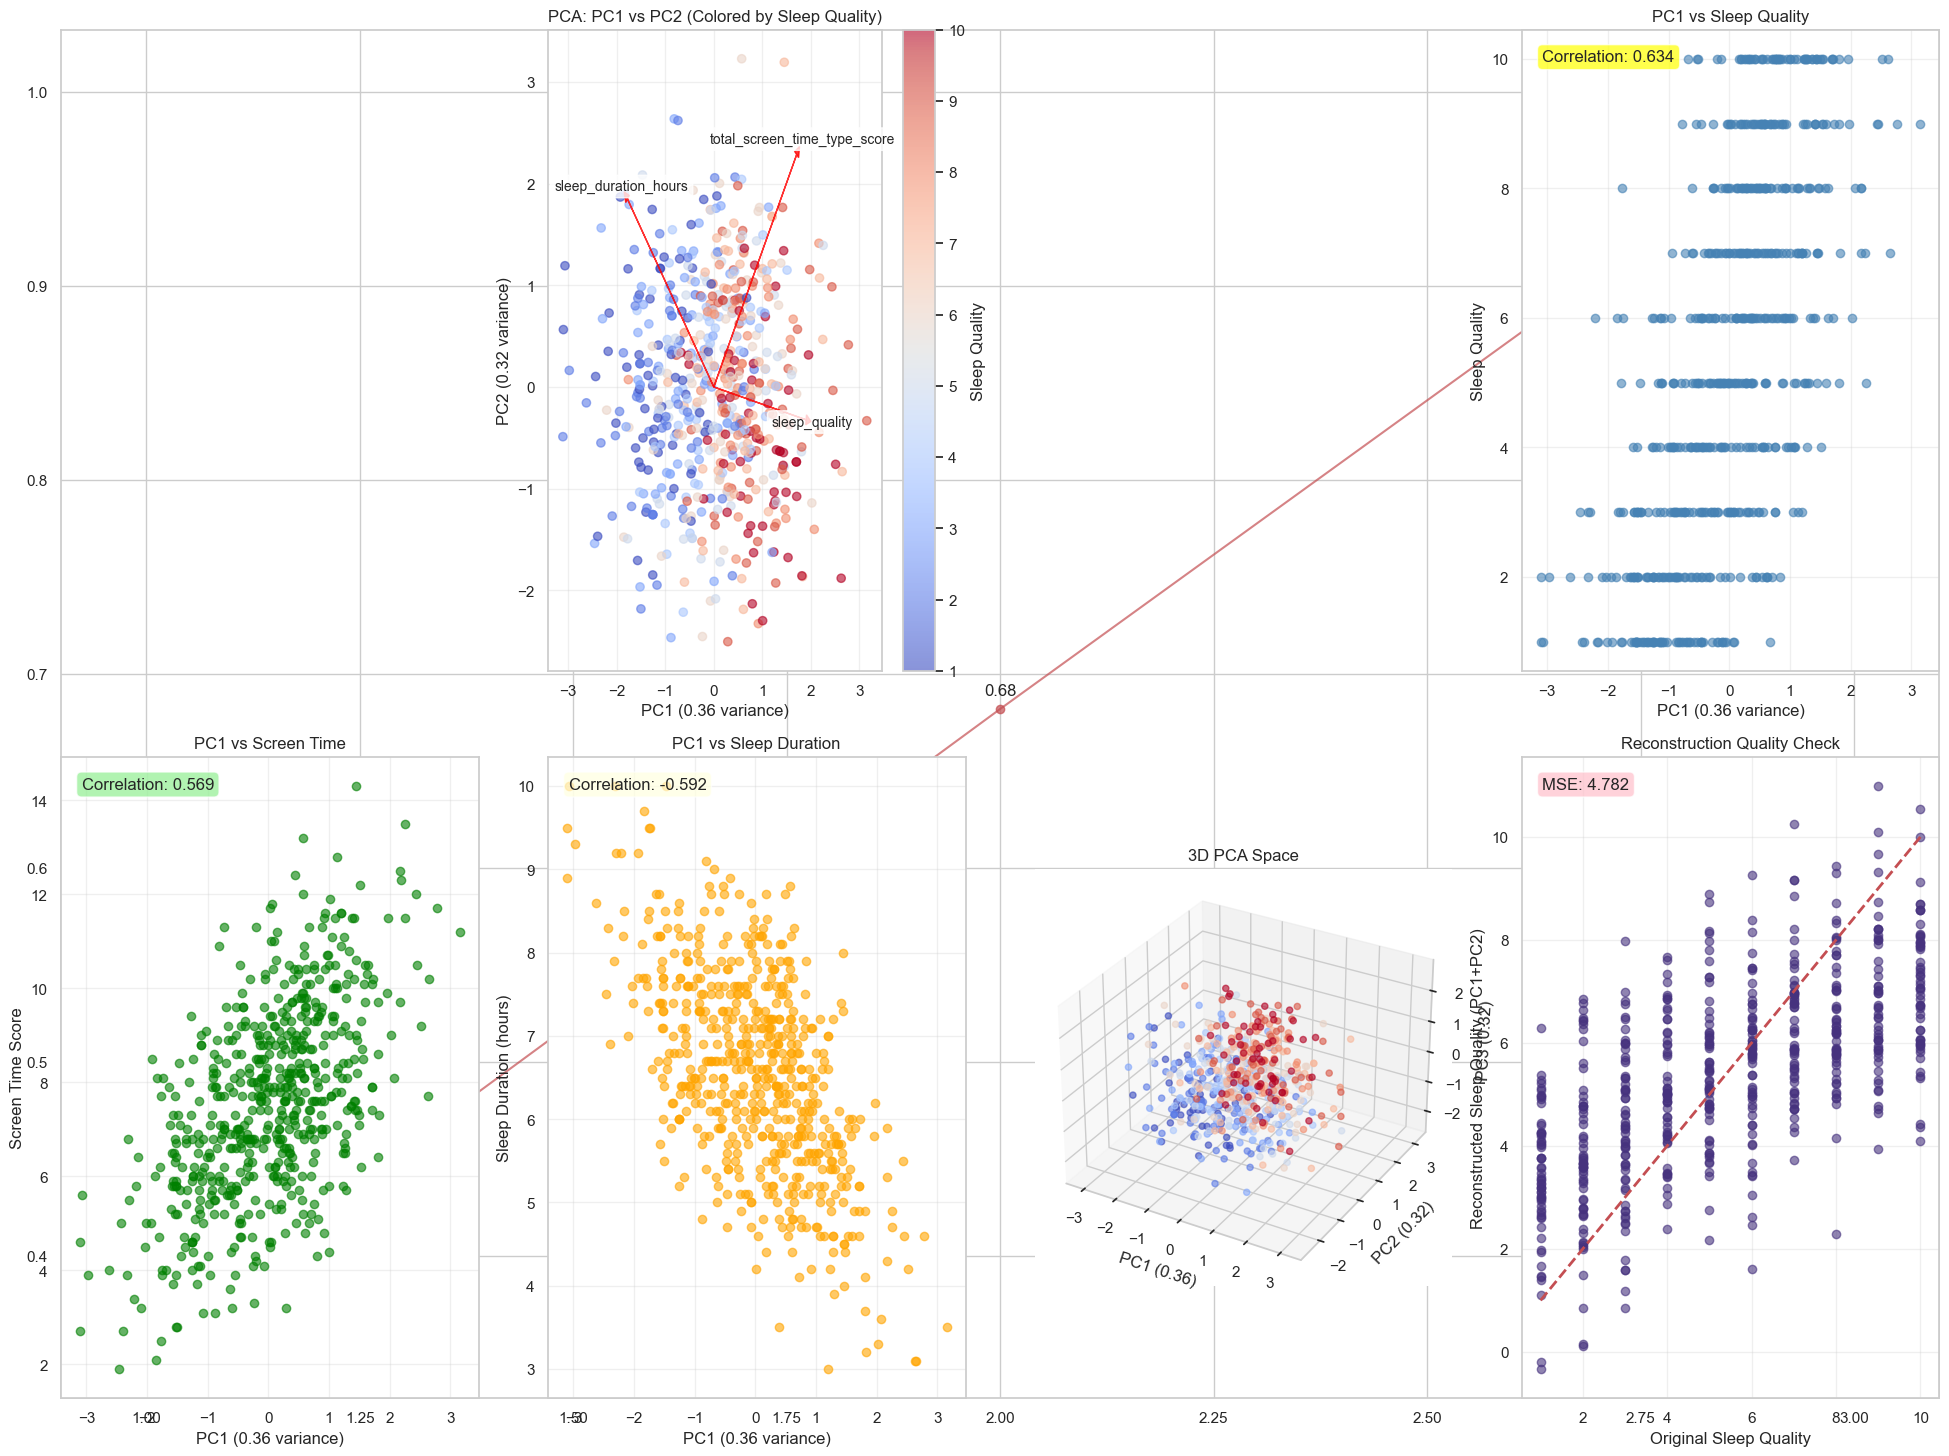

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Assuming your data is in filtered_df with columns:
# 'total_screen_time_type_score', 'sleep_duration_hours', 'sleep_quality'

# Prepare the data for PCA
features = ['total_screen_time_type_score', 'sleep_duration_hours', 'sleep_quality']
X = filtered_df[features].dropna()

print(f"Data shape: {X.shape}")
print(f"Features: {features}")
print(f"First few rows:\n{X.head()}")

# Convert to numpy array and ensure proper indexing
X_array = X.values
screen_time = X_array[:, 0]
sleep_duration = X_array[:, 1] 
sleep_quality = X_array[:, 2]

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_array)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create comprehensive PCA analysis plots
fig = plt.figure(figsize=(20, 15))

# Add cumulative variance line
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumsum) + 1), cumsum, 'ro-', alpha=0.7)
for i, cum in enumerate(cumsum):
    plt.annotate(f'{cum:.2f}', (i+1, cum), textcoords="offset points", xytext=(0,10), ha='center')

# 2. PCA Biplot (PC1 vs PC2)
plt.subplot(2, 4, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=sleep_quality, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Sleep Quality')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} variance)')
plt.title('PCA: PC1 vs PC2 (Colored by Sleep Quality)')
plt.grid(True, alpha=0.3)

# Add loading vectors
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, (loading, feature) in enumerate(zip(loadings, features)):
    plt.arrow(0, 0, loading[0]*3, loading[1]*3, head_width=0.1, 
              head_length=0.1, fc='red', ec='red', alpha=0.8)
    plt.text(loading[0]*3.2, loading[1]*3.2, feature, 
             fontsize=10, ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 4. PC1 vs Original Sleep Quality
plt.subplot(2, 4, 4)
plt.scatter(X_pca[:, 0], sleep_quality, alpha=0.6, color='steelblue')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} variance)')
plt.ylabel('Sleep Quality')
plt.title('PC1 vs Sleep Quality')
plt.grid(True, alpha=0.3)

# Calculate and plot correlation
correlation = np.corrcoef(X_pca[:, 0], sleep_quality)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# 5. PC1 vs Screen Time
plt.subplot(2, 4, 5)
plt.scatter(X_pca[:, 0], screen_time, alpha=0.6, color='green')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} variance)')
plt.ylabel('Screen Time Score')
plt.title('PC1 vs Screen Time')
plt.grid(True, alpha=0.3)

correlation_screen = np.corrcoef(X_pca[:, 0], screen_time)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation_screen:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

# 6. PC1 vs Sleep Duration
plt.subplot(2, 4, 6)
plt.scatter(X_pca[:, 0], sleep_duration, alpha=0.6, color='orange')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} variance)')
plt.ylabel('Sleep Duration (hours)')
plt.title('PC1 vs Sleep Duration')
plt.grid(True, alpha=0.3)

correlation_duration = np.corrcoef(X_pca[:, 0], sleep_duration)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation_duration:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7))

# 7. 3D PCA Plot
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(2, 4, 7, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                    c=sleep_quality, cmap='coolwarm', alpha=0.6)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2f})')
ax.set_title('3D PCA Space')

# 8. Reconstruction Quality Check
plt.subplot(2, 4, 8)
# Reconstruct using only PC1 and PC2
X_reconstructed = pca.inverse_transform(np.column_stack([X_pca[:, 0], X_pca[:, 1], np.zeros(len(X_pca))]))
X_reconstructed = scaler.inverse_transform(X_reconstructed)

# Plot original vs reconstructed sleep quality
plt.scatter(sleep_quality, X_reconstructed[:, 2], alpha=0.6)
plt.plot([sleep_quality.min(), sleep_quality.max()], [sleep_quality.min(), sleep_quality.max()], 'r--', lw=2)
plt.xlabel('Original Sleep Quality')
plt.ylabel('Reconstructed Sleep Quality (PC1+PC2)')
plt.title('Reconstruction Quality Check')
plt.grid(True, alpha=0.3)

# Calculate reconstruction error
reconstruction_error = np.mean((sleep_quality - X_reconstructed[:, 2])**2)
plt.text(0.05, 0.95, f'MSE: {reconstruction_error:.3f}', 
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="pink", alpha=0.7))

plt.tight_layout()
plt.show()



Text(602.326766304348, 0.5, 'Original Features')

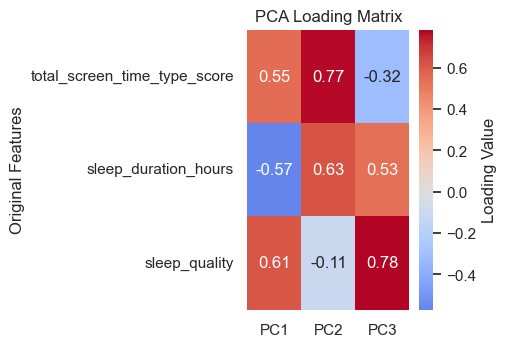

In [15]:
# 3. Loading Matrix Heatmap
plt.subplot(2, 4, 3)
loading_matrix = pd.DataFrame(pca.components_.T, 
                             columns=[f'PC{i+1}' for i in range(len(features))],
                             index=features)
sns.heatmap(loading_matrix, annot=True, cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Loading Value'})
plt.title('PCA Loading Matrix')
plt.ylabel('Original Features')

In [16]:

# Print detailed analysis
print("=== PCA ANALYSIS RESULTS ===")
print(f"Number of samples: {len(X_array)}")
print(f"Number of features: {len(features)}")
print()

print("Explained Variance Ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.1f}%)")
print(f"  Total variance explained by PC1+PC2: {sum(pca.explained_variance_ratio_[:2])*100:.1f}%")
print()

print("Principal Component Loadings:")
for i, component in enumerate(pca.components_):
    print(f"  PC{i+1}:")
    for j, (loading, feature) in enumerate(zip(component, features)):
        print(f"    {feature}: {loading:.4f}")
print()

print("Feature Contributions to PC1:")
pc1_loadings = pca.components_[0]
for loading, feature in sorted(zip(abs(pc1_loadings), features), reverse=True):
    original_loading = pc1_loadings[features.index(feature)]
    print(f"  {feature}: {original_loading:.4f} (|{loading:.4f}|)")
print()

print("Interpretation:")
print("- PC1 represents the main pattern of variation in your sleep data")
print("- Higher absolute loading values indicate stronger influence on that component")
print("- The biplot shows how your original variables relate to the principal components")
print("- Points clustered together have similar sleep patterns")

# Additional insights based on the loadings
pc1_interpretation = []
for i, (loading, feature) in enumerate(zip(pca.components_[0], features)):
    if abs(loading) > 0.5:  # Strong loading
        direction = "increases" if loading > 0 else "decreases"
        pc1_interpretation.append(f"{feature} {direction}")

if pc1_interpretation:
    print(f"- PC1 primarily captures variation where: {', '.join(pc1_interpretation)}")

=== PCA ANALYSIS RESULTS ===
Number of samples: 591
Number of features: 3

Explained Variance Ratio:
  PC1: 0.3586 (35.9%)
  PC2: 0.3232 (32.3%)
  PC3: 0.3182 (31.8%)
  Total variance explained by PC1+PC2: 68.2%

Principal Component Loadings:
  PC1:
    total_screen_time_type_score: 0.5483
    sleep_duration_hours: -0.5712
    sleep_quality: 0.6108
  PC2:
    total_screen_time_type_score: 0.7729
    sleep_duration_hours: 0.6251
    sleep_quality: -0.1093
  PC3:
    total_screen_time_type_score: -0.3194
    sleep_duration_hours: 0.5320
    sleep_quality: 0.7842

Feature Contributions to PC1:
  sleep_quality: 0.6108 (|0.6108|)
  sleep_duration_hours: -0.5712 (|0.5712|)
  total_screen_time_type_score: 0.5483 (|0.5483|)

Interpretation:
- PC1 represents the main pattern of variation in your sleep data
- Higher absolute loading values indicate stronger influence on that component
- The biplot shows how your original variables relate to the principal components
- Points clustered together ha